In [27]:
import requests
import json
import prettytable

import pandas as pd

Note: `prettytable` is a Python package which may need to be instlled: `pip install prettytable`   
> *PrettyTable is a simple Python library designed to make it quick and easy to represent tabular data in visually appealing ASCII tables.*   

https://pypi.python.org/pypi/PrettyTable

In [102]:
# an array of strings which represent BLS Series IDs
seriesID = ['LAUMT423798000000003']
seriesID = ['LAUCT426000000000003']

startYear = 2016
endYear = 2017

In [103]:
seriesID

['LAUCT426000000000003']

In [104]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": seriesID,"startyear":"{}".format(startYear), "endyear":"{}".format(endYear)})

In [105]:
data

'{"seriesid": ["LAUCT426000000000003"], "startyear": "2016", "endyear": "2017"}'

In [106]:
# get the data using API
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)

In [107]:
p

<Response [200]>

In [108]:
json_data = json.loads(p.text)

In [109]:
json_data

{'Results': {'series': [{'data': [{'footnotes': [{'code': 'P',
        'text': 'Preliminary.'}],
      'period': 'M08',
      'periodName': 'August',
      'value': '6.7',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M07',
      'periodName': 'July',
      'value': '6.9',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M06',
      'periodName': 'June',
      'value': '6.4',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M05',
      'periodName': 'May',
      'value': '6.7',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M04',
      'periodName': 'April',
      'value': '5.9',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M03',
      'periodName': 'March',
      'value': '6.0',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M02',
      'periodName': 'February',
      'value': '6.2',
      'year': '2017'},
     {'footnotes': [{}],
      'period': 'M01',
      'periodName': 'Janua

In [110]:
def createEmptyDataFrame(columns, types):
    index = pd.Index([], name="id", dtype=int)
    # specify column name and data type 
    coldefs = zip(columns, types)
    columns = []
    for coldef in coldefs:
        columns.append(coldef)
    # create the dataframe from a dict
    return pd.DataFrame({k: pd.Series(dtype=t) for k, t in columns})

# decode the Month

In [245]:
code2month = {
    "M01" : "January",
    "M02" : "February",
    "M03" : "March",
    "M04" : "April",
    "M05" : "May",
    "M06" : "June",
    "M07" : "July",
    "M08" : "August",
    "M09" : "September",
    "M10" : "October",
    "M11" : "November",
    "M12" : "December"
}

month2number = {
    "January" : "01",
    "February" : "02",
    "March" : "03",
    "April" : "04",
    "May" : "05",
    "June" : "06",
    "July" : "07",
    "August" : "08",
    "September" : "09",
    "October" : "10",
    "November" : "11",
    "December" : "12"
}

def dateFrom(year, month):
    return "{}/{}".format(year,month2number[month])


In [244]:
dateFrom("2017","October")

'2017/10'

# decode the City/Town

In [162]:
code2citytown = {}
citytown2code = {}

file = open("bls-cities-and-towns.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, citytownstate = line.rstrip().split(">", 2)[1].split(" ",2)
    citytown, state = citytownstate.split(",")
    code2citytown[code]=citytown
    citytown2code[citytown]=code
    #print("line: {} code: {} citytownstate: {}, citytown: {}, state: {}".format(count, code, citytownstate, citytown, state))

file.close()

def decodeCityTown(s):
    code = s[3:len(s)-2]
    return code2citytown[code]

import re
def searchDictionary(d, city):
    #print("searching for:", city)
    res = []
    for key in d.keys():
        if re.match(city, key):
            res.append(d[key])
    return res

def findCityTownCode(city):
    return searchDictionary(citytown2code, city)

In [160]:
decodeCityTown('LAUCT426000000000003')

'Philadelphia County/city'

In [161]:
findCityTownCode('Baltimore')

['CT2404000000000']

# decode the State

In [134]:
code2state = {}

file = open("bls-state-codes.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, state = line.rstrip().split(">", 2)[1].split(" ",2)
    code2state[code]=state
    #print("line: {} code: {} state: {}".format(count, code, state))

file.close()

def decodeState(s):
    code = s[5:7]
    return code2state[code]

In [114]:
s = 'LAUMT423798000000003'

In [115]:
decodeState(s)

'Pennsylvania'

In [120]:
len(s)

20

In [123]:
s[len(s)-2:]

'03'

# decode the Measure

In [126]:
code2measure = {
    "03" : "unemployment-rate",
    "04" : "unemployment",
    "05" : "employment",
    "06" : "labor-force"
}
def decodeMeasure(s):
    code = s[len(s)-2:]
    return code2measure[code]

In [246]:
colNames = ["seriesid","year","month","period","date","state","city","measure","value","footnotes"]

# extract the response into a PrettyTable

In [247]:
data = []
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(colNames)
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        month = code2month[period]
        date = dateFrom(year, month)
        state = decodeState(seriesId)
        city = decodeCityTown(seriesId)
        measure = decodeMeasure(seriesId)
        value = item['value']
        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            row = [seriesId,year,month,period,date,state,city,measure,value,footnotes[0:-1]]
            x.add_row(row)
            data.append(row)

In [248]:
x

In [249]:
print(x)

+----------------------+------+-----------+--------+---------+--------------+--------------------------+-------------------+-------+--------------+
|       seriesid       | year |   month   | period |   date  |    state     |           city           |      measure      | value |  footnotes   |
+----------------------+------+-----------+--------+---------+--------------+--------------------------+-------------------+-------+--------------+
| LAUCT426000000000003 | 2017 |   August  |  M08   | 2017/08 | Pennsylvania | Philadelphia County/city | unemployment-rate |  6.7  | Preliminary. |
| LAUCT426000000000003 | 2017 |    July   |  M07   | 2017/07 | Pennsylvania | Philadelphia County/city | unemployment-rate |  6.9  |              |
| LAUCT426000000000003 | 2017 |    June   |  M06   | 2017/06 | Pennsylvania | Philadelphia County/city | unemployment-rate |  6.4  |              |
| LAUCT426000000000003 | 2017 |    May    |  M05   | 2017/05 | Pennsylvania | Philadelphia County/city | unemplo

LAUCT426000000000003
+++
   CT2404000000000

In [250]:
code = 'LAUCT240400000000003'
city = 'CT2404000000000'
xtrc = code[3:len(code)-2]

if city == xtrc:
    print("yes")
else:
    print("no")


yes


In [251]:
data

[['LAUCT426000000000003',
  '2017',
  'August',
  'M08',
  '2017/08',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.7',
  'Preliminary.'],
 ['LAUCT426000000000003',
  '2017',
  'July',
  'M07',
  '2017/07',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.9',
  ''],
 ['LAUCT426000000000003',
  '2017',
  'June',
  'M06',
  '2017/06',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.4',
  ''],
 ['LAUCT426000000000003',
  '2017',
  'May',
  'M05',
  '2017/05',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.7',
  ''],
 ['LAUCT426000000000003',
  '2017',
  'April',
  'M04',
  '2017/04',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '5.9',
  ''],
 ['LAUCT426000000000003',
  '2017',
  'March',
  'M03',
  '2017/03',
  'Pennsylvania',
  'Philadelphia County/city',
  'unemployment-rate',
  '6.0',
  ''],
 ['LAUCT426000000000003',
  '2017',
  'February',
  'M0

In [252]:
df = pd.DataFrame(data, columns=colNames)

In [253]:
df

,seriesid,year,month,period,date,state,city,measure,value,footnotes
0,LAUCT426000000000003,2017,August,M08,2017/08,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,Preliminary.
1,LAUCT426000000000003,2017,July,M07,2017/07,Pennsylvania,Philadelphia County/city,unemployment-rate,6.9,
2,LAUCT426000000000003,2017,June,M06,2017/06,Pennsylvania,Philadelphia County/city,unemployment-rate,6.4,
3,LAUCT426000000000003,2017,May,M05,2017/05,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,
4,LAUCT426000000000003,2017,April,M04,2017/04,Pennsylvania,Philadelphia County/city,unemployment-rate,5.9,
5,LAUCT426000000000003,2017,March,M03,2017/03,Pennsylvania,Philadelphia County/city,unemployment-rate,6.0,
6,LAUCT426000000000003,2017,February,M02,2017/02,Pennsylvania,Philadelphia County/city,unemployment-rate,6.2,
7,LAUCT426000000000003,2017,January,M01,2017/01,Pennsylvania,Philadelphia County/city,unemployment-rate,6.1,
8,LAUCT426000000000003,2016,December,M12,2016/12,Pennsylvania,Philadelphia County/city,unemployment-rate,5.8,
9,LAUCT426000000000003,2016,November,M11,2016/11,Pennsylvania,Philadelphia County/city,unemployment-rate,6.2,


In [183]:
dateRange = [list(a) for a in zip(df.month,df.year)]

In [191]:
dateRange

[['August', '2017'],
 ['July', '2017'],
 ['June', '2017'],
 ['May', '2017'],
 ['April', '2017'],
 ['March', '2017'],
 ['February', '2017'],
 ['January', '2017'],
 ['December', '2016'],
 ['November', '2016'],
 ['October', '2016'],
 ['September', '2016'],
 ['August', '2016'],
 ['July', '2016'],
 ['June', '2016'],
 ['May', '2016'],
 ['April', '2016'],
 ['March', '2016'],
 ['February', '2016'],
 ['January', '2016']]

In [212]:
def doit(item):
    return "{}, {}".format(item[0], item[1])

result = list(map(doit, dateRange))

In [231]:
print(result)

['August, 2017', 'July, 2017', 'June, 2017', 'May, 2017', 'April, 2017', 'March, 2017', 'February, 2017', 'January, 2017', 'December, 2016', 'November, 2016', 'October, 2016', 'September, 2016', 'August, 2016', 'July, 2016', 'June, 2016', 'May, 2016', 'April, 2016', 'March, 2016', 'February, 2016', 'January, 2016']


In [233]:
type(result)

list

In [234]:
dates = []
dates = result

In [235]:
dates

['August, 2017',
 'July, 2017',
 'June, 2017',
 'May, 2017',
 'April, 2017',
 'March, 2017',
 'February, 2017',
 'January, 2017',
 'December, 2016',
 'November, 2016',
 'October, 2016',
 'September, 2016',
 'August, 2016',
 'July, 2016',
 'June, 2016',
 'May, 2016',
 'April, 2016',
 'March, 2016',
 'February, 2016',
 'January, 2016']

In [236]:
type(dates)

list

In [214]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

AttributeError: 'AxesSubplot' object has no attribute 'autofmt_xdate'

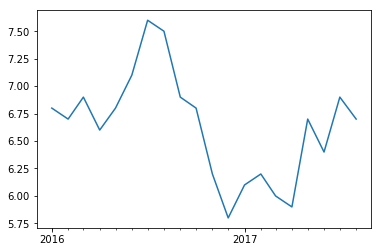

In [271]:
import matplotlib.dates as mdates

x = list([dt.datetime.strptime(d,'%Y/%m').date() for d in df.date.values])
y = list(df.value.values)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()

ax.plot(x, y)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.autofmt_xdate()
ax.format_xdata = mdates.DateFormatter('%Y/%m')
ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [261]:
import datetime as dt

x = [dt.datetime.strptime(d,'%Y/%m').date() for d in df.date.values]
y = df.value.values

In [262]:
x

[datetime.date(2017, 8, 1),
 datetime.date(2017, 7, 1),
 datetime.date(2017, 6, 1),
 datetime.date(2017, 5, 1),
 datetime.date(2017, 4, 1),
 datetime.date(2017, 3, 1),
 datetime.date(2017, 2, 1),
 datetime.date(2017, 1, 1),
 datetime.date(2016, 12, 1),
 datetime.date(2016, 11, 1),
 datetime.date(2016, 10, 1),
 datetime.date(2016, 9, 1),
 datetime.date(2016, 8, 1),
 datetime.date(2016, 7, 1),
 datetime.date(2016, 6, 1),
 datetime.date(2016, 5, 1),
 datetime.date(2016, 4, 1),
 datetime.date(2016, 3, 1),
 datetime.date(2016, 2, 1),
 datetime.date(2016, 1, 1)]

In [263]:
y

array(['6.7', '6.9', '6.4', '6.7', '5.9', '6.0', '6.2', '6.1', '5.8',
       '6.2', '6.8', '6.9', '7.5', '7.6', '7.1', '6.8', '6.6', '6.9',
       '6.7', '6.8'], dtype=object)

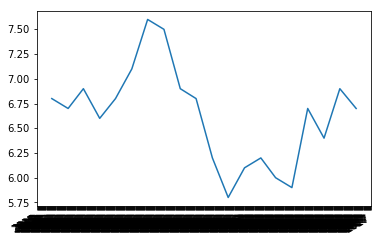

In [266]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(list(x),list(y))
plt.gcf().autofmt_xdate()

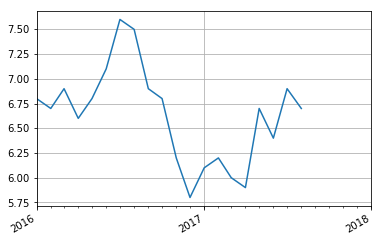

In [279]:
"""
================
Date tick labels
================

Show how to make date plots in matplotlib using date tick locators and
formatters.  See major_minor_demo1.py for more information on
controlling major and minor ticks

All matplotlib date plotting is done by converting date instances into
days since the 0001-01-01 UTC.  The conversion, tick locating and
formatting is done behind the scenes so this is most transparent to
you.  The dates module provides several converter functions date2num
and num2date

"""
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df.date.values])
y = list(df.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [278]:
min(x).year

2016